In [4]:
import torch
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [5]:
# Helper

def find_animal_name(path):
    return path.split("/")[-1].split(".")[0]

def find_names_of_all_animals(paths):

    names = []

    for path in paths:
        animal_name = find_animal_name(path)
        names.append(animal_name)

    return names

def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)


def display_tensor_image(tensor_image):

    # CxHxW to HxWxC and from tensor to numpy array
    image_np = tensor_image.permute(1, 2, 0).numpy()
    
    # Convert numpy array to Pillow Image
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8))
    
    # Display the image using matplotlib
    plt.imshow(image_pil)
    plt.axis('off')
    plt.show()

<IPython.core.display.Javascript object>

## Prepare the data

In [6]:
data_train = "cats_dogs_light/train"
data_test = "cats_dogs_light/test"

<IPython.core.display.Javascript object>

In [7]:
# list comprehension
train_animal_paths = [os.path.join(data_train, f) for f in os.listdir(data_train)]

test_animal_paths = [os.path.join(data_test, f) for f in os.listdir(data_test)]

<IPython.core.display.Javascript object>

In [8]:
print("Length of train_animal_paths: ", len(train_animal_paths))
print("Length of test_animal_paths: ", len(test_animal_paths))

Length of train_animal_paths:  1000
Length of test_animal_paths:  400


<IPython.core.display.Javascript object>

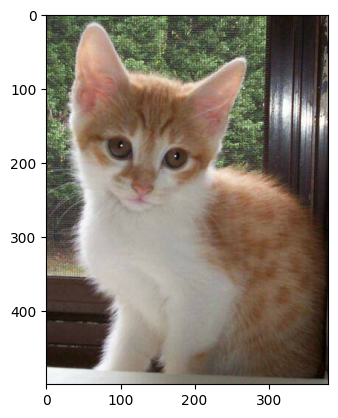

<IPython.core.display.Javascript object>

In [9]:
display_image(train_animal_paths[0])

In [10]:
train_animal_names = [find_animal_name(path) for path in train_animal_paths]

test_animal_names = [find_animal_name(path) for path in test_animal_paths]

<IPython.core.display.Javascript object>

In [11]:
# Write now we have the data as well as the ground truth for the data

<IPython.core.display.Javascript object>

## Create a PyToch Dataloader

In [12]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

<IPython.core.display.Javascript object>

In [13]:
class CatDogDataset(Dataset):

    # like a constructor in c++
    def __init__(self, path_list, name_list):
            
            self.path_list = path_list
            self.name_list = name_list

            label_mapping = {"cat": 0, "dog": 1}

            self.label_list = [label_mapping[name] for name in name_list]

    
    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self, idx):

        image_path = self.path_list[idx]
        label = self.label_list[idx]
        
        # Load the image
        image = Image.open(image_path).convert("RGB")
        image = image.resize((224, 224))
        
        # convert to numpy array
        image = np.array(image)

        # normalize the image from 0-255 to 0-1
        image = image / 255.0

        # pillow: H x W x C
        # pytorch: C x H x W
        
        # reshape image for pytorch
        image = torch.tensor(image).permute(2, 0, 1).float()
        label = torch.tensor(label).long()

        return image, label

        # afterwe put into dataloader
        # [image1, image2,.... image32], [label1, label2, ... label32]

<IPython.core.display.Javascript object>

In [14]:
train_dataset = CatDogDataset(train_animal_paths, train_animal_names)

print("Length of train_dataset: ", len(train_dataset))

Length of train_dataset:  1000


<IPython.core.display.Javascript object>

In [15]:
test_dataset = CatDogDataset(test_animal_paths, test_animal_names)
print("Length of test_dataset: ", len(test_dataset))

Length of test_dataset:  400


<IPython.core.display.Javascript object>

In [16]:
animal_photo, animal_name = train_dataset[0]
animal_name

tensor(0)

<IPython.core.display.Javascript object>

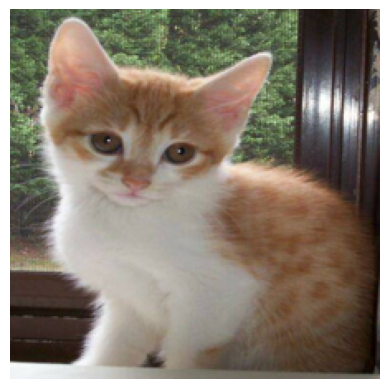

<IPython.core.display.Javascript object>

In [17]:
display_tensor_image(animal_photo)

### DataLoader

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

<IPython.core.display.Javascript object>

In [19]:
a = iter(train_dataloader)
b = next(a)

<IPython.core.display.Javascript object>

In [20]:
animals = b[0]

animal_names = b[1]

<IPython.core.display.Javascript object>

In [21]:
len(animals)

32

<IPython.core.display.Javascript object>

In [22]:
len(animal_names)

32

<IPython.core.display.Javascript object>

In [23]:
animals[0]

tensor([[[0.1725, 0.1686, 0.1686,  ..., 0.4039, 0.3412, 0.2941],
         [0.1176, 0.1608, 0.2353,  ..., 0.3608, 0.3412, 0.3216],
         [0.1059, 0.1765, 0.2902,  ..., 0.3490, 0.3765, 0.3843],
         ...,
         [0.0667, 0.0784, 0.1020,  ..., 0.4235, 0.4431, 0.3922],
         [0.0980, 0.0549, 0.0824,  ..., 0.5176, 0.4627, 0.3529],
         [0.0902, 0.0471, 0.0824,  ..., 0.6784, 0.6353, 0.5216]],

        [[0.2196, 0.2157, 0.2078,  ..., 0.5373, 0.4706, 0.4353],
         [0.1647, 0.2078, 0.2824,  ..., 0.4863, 0.4745, 0.4627],
         [0.1647, 0.2353, 0.3412,  ..., 0.4745, 0.5059, 0.5137],
         ...,
         [0.1020, 0.1176, 0.1216,  ..., 0.5059, 0.5333, 0.4902],
         [0.1333, 0.0902, 0.1020,  ..., 0.5765, 0.5294, 0.4314],
         [0.1255, 0.0863, 0.1020,  ..., 0.7333, 0.6941, 0.5804]],

        [[0.0627, 0.0588, 0.0667,  ..., 0.3412, 0.2863, 0.2471],
         [0.0078, 0.0471, 0.1373,  ..., 0.2941, 0.2902, 0.2745],
         [0.0039, 0.0667, 0.1961,  ..., 0.2941, 0.3294, 0.

<IPython.core.display.Javascript object>

In [24]:
animal_names[31]

tensor(1)

<IPython.core.display.Javascript object>

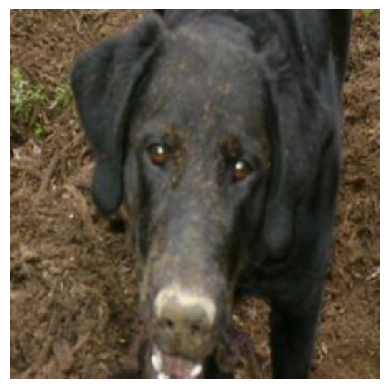

<IPython.core.display.Javascript object>

In [25]:
display_tensor_image(animals[31])

## Create a PyTorch Model

In [26]:
class CNN(nn.Module):

    def __init__(self, num_of_input_channels, num_of_classes, dropout_prob=0.2):
        super().__init__()

        # Convolutional layers
        self.conv = nn.Sequential(
            # conv layer 1
            nn.Conv2d(num_of_input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # conv layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Dense layers
        self.dense = nn.Sequential(
            nn.Linear(64*56*56, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        # Output layer
        self.out = nn.Linear(128, num_of_classes)
    
    def forward(self, x):
        x = self.conv(x)

        x = x.view(x.size(0), -1)

        x = self.dense(x)
        x = self.out(x)

        return x

<IPython.core.display.Javascript object>

In [27]:
data = torch.randn(32, 3, 224, 224)

model = CNN(3, 2)

<IPython.core.display.Javascript object>

In [28]:
# pass the data through the model: forward pass

output = model(data)

print(output.shape)

torch.Size([32, 2])


<IPython.core.display.Javascript object>

In [29]:
class ColorHistogram:
    """
    This is a dummy class for color histogram feature extraction
    """

    def __init__(self, image_path):
         # Load the image
        image = Image.open(image_path).convert("RGB")
        image = image.resize((224, 224))
        
        # convert to numpy array
        image = np.array(image)

        # normalize the image from 0-255 to 0-1
        image = image / 255.0

        self.image = image

    def get_thisimage_features(self):
        return self.image

<IPython.core.display.Javascript object>

In [30]:
class CatDogDataset(Dataset):

    # like a constructor in c++
    def __init__(self, path_list, name_list):
            
            self.path_list = path_list
            self.name_list = name_list

            label_mapping = {"cat": 0, "dog": 1}

            self.label_list = [label_mapping[name] for name in name_list]

    
    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self, idx):

        image_path = self.path_list[idx]
        label = self.label_list[idx]
        
        # Load the image
        image = Image.open(image_path).convert("RGB")
        image = image.resize((224, 224))
        
        # convert to numpy array
        image = np.array(image)

        # normalize the image from 0-255 to 0-1
        image = image / 255.0

        # pillow: H x W x C
        # pytorch: C x H x W
        
        # reshape image for pytorch
        image = torch.tensor(image).permute(2, 0, 1).float()
        label = torch.tensor(label).long()

        # create histogram of the image
        hist = ColorHistogram(image_path)
        hist = hist.get_thisimage_features()

        hist = hist.permute(2, 0, 1).float()

        return image, hist, label

        # afterwe put into dataloader
        # [image1, image2,.... image32], [label1, label2, ... label32]

<IPython.core.display.Javascript object>

In [ ]:
for epoch in epochs:

    for image, hist, label in enumerate(train_dataloader):

        # forward pass
        output = model(image)

        # compute loss
        loss = loss_function(output, label)

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        # zero the gradients
        optimizer.zero_grad()